# 0 Setting up directory

### 0.0 Select your directory
Choose the correct directory for google drive / desktop

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
# data_dir = 'drive/MyDrive/balgrist/data/experiment/'
data_dir = '/Users/askr/Desktop/Courses/Balgrist/Data/'

### 0.0 Import packages

In [3]:
# for google colab only
# !pip install scipy --upgrade

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from scipy.signal import ShortTimeFFT, butter, welch, detrend, filtfilt
from scipy.signal.windows import gaussian
from scipy.integrate import simpson
import seaborn as sns

print(scipy.__version__) # Make sure it is 1.12.0 (or larger)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

1.13.0
Using device: cpu


# 1 Extract the data
**Input**: raw data (experiment and eeg) for a participant from data directory

**Output**: paired data (trimmed eeg), saved in the data directory

If you have a new participant, run this to get the trimmed eeg data. Otherwise skip.

### 1.0 Select the participant

In [5]:
participant = "01"
# participant = "02"
# participant = "03"
# participant = "04"
# participant = "05"

### 1.1 Read file to pandas df

In [6]:
file_name_eeg = participant+"_eeg.csv"
file_name_experiment = participant + "_exp.csv"

eeg_df = pd.read_csv(data_dir+file_name_eeg)
experiment_df = pd.read_csv(data_dir+file_name_experiment)

### 1.2 Find the timestamp of begin and end in the experiment dataframe

In [7]:
begin_idx = experiment_df[experiment_df['Response'] == 'BEGIN'].index.min()
end_idx = experiment_df[experiment_df['Response'] == 'END'].index.min()
filtered_df = experiment_df.iloc[begin_idx:end_idx]

# important! The final row with END is the END frame. The timestamp of it
# is the end time of END frame, not the end time of our last frame
end_idx -= 1 # this is related to how the experiment dataframe is structured

### 1.3 Calculate the begin and end using the indices

In [8]:
begin_timestamp_ms = experiment_df.at[begin_idx, 'UTC Timestamp'] # ms
end_timestamp_ms = experiment_df.at[end_idx, 'UTC Timestamp'] # ms
print(begin_timestamp_ms/1000, end_timestamp_ms/1000, end_timestamp_ms/1000 - begin_timestamp_ms/1000)

1711458760.165 1711459090.172 330.0069999694824


### 1.4 Make sure all data are 330 seconds.
If it is not 330, but instead 299.994, we increase it by a few miliseconds so that when we batch it later, the last one doesnt get chunked off when we have a chunk size of 1s. (In my code I neglect the last chunk if the leftover chunk is smaller than chunk size.)

In [ ]:
while end_timestamp_ms - begin_timestamp_ms <= 330000:
    print("Total time smaller than 330. Incrementing by 1.")
    end_timestamp_ms += 1

begin_timestamp = begin_timestamp_ms / 1000 # s
end_timestamp = end_timestamp_ms / 1000 # s
print(begin_timestamp, end_timestamp, end_timestamp - begin_timestamp)

1712847126.531 1712847456.544 330.0130000114441


### 1.5 Trim the eeg data using the time stamps and visualize it

In [ ]:
paired_eeg_data = eeg_df[(eeg_df['timestamp'] >= begin_timestamp) & (eeg_df['timestamp'] <= end_timestamp)]
paired_eeg_data.to_csv(data_dir+participant+'_paired.csv', index=False)
paired_eeg_data

,timestamp,ch1
58590,1.712847e+09,-11049.875444
58591,1.712847e+09,-11052.244729
58592,1.712847e+09,-11058.279700
58593,1.712847e+09,-11053.339965
58594,1.712847e+09,-11042.208796
...,...,...
141089,1.712847e+09,-13944.292241
141090,1.712847e+09,-13935.955040
141091,1.712847e+09,-13933.921031
141092,1.712847e+09,-13934.278659


### 1.6 Get the time marker for each trial (hold)

In [10]:
experiment_df

,Event Index,UTC Timestamp,UTC Date and Time,Local Timestamp,Local Timezone,Local Date and Time,Experiment ID,Experiment Version,Tree Node Key,Repeat Key,...,Object Name,Object Number,Object ID,Spreadsheet: display,Spreadsheet: Question,Spreadsheet: Left Answer,Spreadsheet: Right Answer,Spreadsheet: Correct Answer,Spreadsheet: Difficulty,Manipulation: Spreadsheet
0,1,1.711459e+12,26/03/2024 13:12:40,1.711462e+12,1.0,26/03/2024 15:12:40,168142.0,22.0,task-63v2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1.711459e+12,26/03/2024 13:12:45,1.711462e+12,1.0,26/03/2024 15:12:45,168142.0,22.0,task-63v2,NaN,...,screen,0.0,screen,Trials,3 + 1,4,3,Left,1.0,NaN
2,3,1.711459e+12,26/03/2024 13:12:46,1.711462e+12,1.0,26/03/2024 15:12:46,168142.0,22.0,task-63v2,NaN,...,Keyboard Response,4.0,object-67,Trials,3 + 1,4,3,Left,1.0,NaN
3,4,1.711459e+12,26/03/2024 13:12:51,1.711462e+12,1.0,26/03/2024 15:12:51,168142.0,22.0,task-63v2,NaN,...,screen,0.0,screen,Trials,3 + 1,4,3,Left,1.0,NaN
4,5,1.711459e+12,26/03/2024 13:12:56,1.711462e+12,1.0,26/03/2024 15:12:56,168142.0,22.0,task-63v2,NaN,...,screen,0.0,screen,Trials,8 + 7,15,16,Left,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,89,1.711459e+12,26/03/2024 13:18:04,1.711463e+12,1.0,26/03/2024 15:18:04,168142.0,22.0,task-63v2,NaN,...,screen,0.0,screen,Trials,Is the set of all rational numbers <br> betwee...,Yes,No,Left,3.0,NaN
89,90,1.711459e+12,26/03/2024 13:18:05,1.711463e+12,1.0,26/03/2024 15:18:05,168142.0,22.0,task-63v2,NaN,...,Keyboard Response,4.0,object-67,Trials,Is the set of all rational numbers <br> betwee...,Yes,No,Left,3.0,NaN
90,91,1.711459e+12,26/03/2024 13:18:10,1.711463e+12,1.0,26/03/2024 15:18:10,168142.0,22.0,task-63v2,NaN,...,screen,0.0,screen,Trials,Is the set of all rational numbers <br> betwee...,Yes,No,Left,3.0,NaN
91,92,1.711459e+12,26/03/2024 13:18:10,1.711463e+12,1.0,26/03/2024 15:18:10,168142.0,22.0,task-63v2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2 Accuracy report
**Input**: raw data (experiment) for all participants from data directory

**Output**: The individual and average accuracy.

### 2.0 Initialize

In [ ]:
participants = ["01", "02", "03", "04", "05"]

In [ ]:
global_accuracy_dict = {}
global_num_response_dict = {}
total_questions = 10

### 2.1 Read the file and get the accuracy

In [ ]:
for participant in participants:
    file_name_experiment = participant + "_exp.csv"
    try:
        experiment_df = pd.read_csv(data_dir + file_name_experiment)
    except FileNotFoundError:
        print(f"File not found: {data_dir + file_name_experiment}")
        continue

    accuracy_dict = {}
    num_response_dict = {}

    for difficulty in [1, 2, 3]:
        # Select the current difficulty
        df_filtered = experiment_df[experiment_df['Spreadsheet: Difficulty'] == difficulty]
        correct_responses = df_filtered['Response'] == df_filtered['Spreadsheet: Correct Answer']
        accuracy = correct_responses.sum() / total_questions  # Proportion of correct answers

        # Storage
        accuracy_dict[difficulty] = accuracy
        num_response_dict[difficulty] = total_questions

    # Store participant-specific results in the global dictionaries
    global_accuracy_dict[participant] = accuracy_dict
    global_num_response_dict[participant] = num_response_dict


### 2.2 Print the accuracy for each participant and the mean accuracy

In [ ]:
for participant in participants:
    print(f"Participant {participant}:")
    for difficulty in [1, 2, 3]:
        acc = global_accuracy_dict.get(participant, {}).get(difficulty, 'N/A')
        count = global_num_response_dict.get(participant, {}).get(difficulty, 0)
        print(f"- {difficulty}: Accuracy {acc:.2f}")

Participant 01:
- 1: Accuracy 0.90
- 2: Accuracy 0.80
- 3: Accuracy 0.30
Participant 02:
- 1: Accuracy 1.00
- 2: Accuracy 0.60
- 3: Accuracy 0.30
Participant 03:
- 1: Accuracy 1.00
- 2: Accuracy 0.90
- 3: Accuracy 0.30
Participant 04:
- 1: Accuracy 1.00
- 2: Accuracy 0.70
- 3: Accuracy 0.30
Participant 05:
- 1: Accuracy 1.00
- 2: Accuracy 0.80
- 3: Accuracy 0.30


In [ ]:
mean_accuracies = {}
for difficulty in [1, 2, 3]:
    total_accuracy = 0
    num_participants = 0
    for participant in participants:
        if participant in global_accuracy_dict:
            accuracy = global_accuracy_dict[participant].get(difficulty, None)
            if accuracy is not None:
                total_accuracy += accuracy
                num_participants += 1
    if num_participants > 0:
        mean_accuracies[difficulty] = total_accuracy / num_participants
    else:
        mean_accuracies[difficulty] = 'N/A'

print("All participants:")
for difficulty, mean_acc in mean_accuracies.items():
    print(f"- {difficulty}: Mean Accuracy {mean_acc:.2f}" if mean_acc != 'N/A' else "N/A")

All participants:
- 1: Mean Accuracy 0.98
- 2: Mean Accuracy 0.76
- 3: Mean Accuracy 0.30


# 3 EEG Preprocessing

**Input**: paired eeg data that you get from the first step.

**Output**: preprocessed eeg data for the current participant (high-pass, low-pass, plus notch)

### 3.0 Choose the data that you want to analyze

In [568]:
# participant = "01"
# participant = "02"
# participant = "03"
# participant = "04"
participant = "05"

### 3.1 Load the data

In [569]:
eeg_name = participant+"_paired.csv"
eeg_data_df = pd.read_csv(data_dir+eeg_name)
eeg_data = eeg_data_df['ch1']
dimension = len(eeg_data_df) # how long is the data
fs = 250

In [570]:
def plot_signal(signal, title, x=None, y=None, fs=250):
    plt.figure(figsize=(10, 4))
    times = np.arange(len(signal)) / fs
    plt.plot(times, signal)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    if x != None:
        plt.xlim(x)
    if y!= None:
        plt.ylim(y)
    plt.show()

### 3.2 Basic high pass (and low pass)

We can do a high-pass, and then a low pass.

High-pass is mandatory, we need somewhere between 0.1-1 to remove the natural drift of recording environment.

<0.1: natural drift of recording environment

0.1-0.5: you can do this.

0.5-1: you can do this if your participant is children or patient (or not...)

In [571]:
def preprocess_eeg(signal, fs=250):
    # High-pass filter
    hp_cutoff_hz = 1
    b_hp, a_hp = butter(5, hp_cutoff_hz / (fs / 2), 'high')
    signal_hp = filtfilt(b_hp, a_hp, signal)

    # Low-pass filter
    lp_cutoff_hz = 35
    b_lp, a_lp = butter(5, lp_cutoff_hz / (fs / 2), 'low')
    signal_lp = filtfilt(b_lp, a_lp, signal_hp)

    return signal_lp

#### 3.2.1 How does it look like before preprocessing?

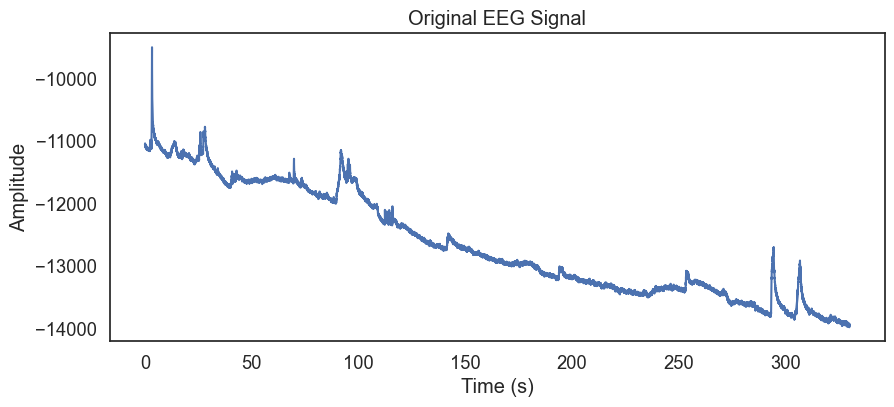

In [572]:
plot_signal(eeg_data, "Original EEG Signal")

#### 3.2.2 How does it look like after the preprocessing?

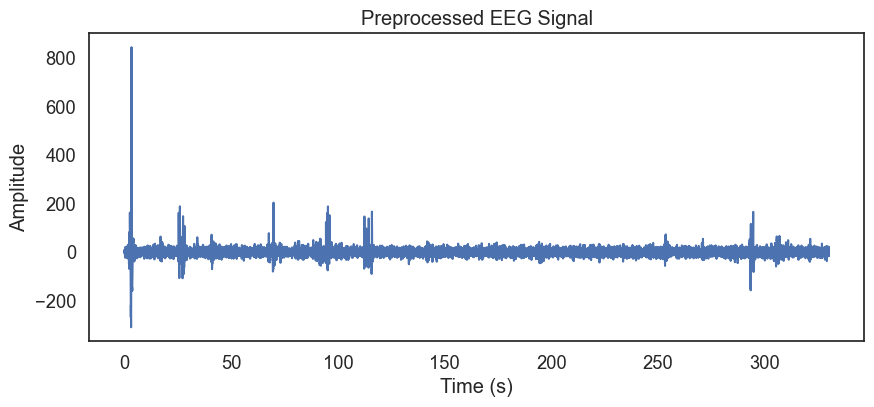

In [573]:
preprocessed_signal = preprocess_eeg(eeg_data)
plot_signal(preprocessed_signal, "Preprocessed EEG Signal")

### 3.3 Notch filter

Design second-order IIR notch digital filter. A notch filter is a band-stop filter with a narrow bandwidth (high quality factor). It rejects a narrow frequency band and leaves the rest of the spectrum little changed.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.iirnotch.html

In [574]:
def apply_notch_filter(preprocessed_signal, notch_freq=50, quality_factor=20, fs=250):
    numerator, denominator = signal.iirnotch(notch_freq, quality_factor, fs)
    filtered_signal = signal.filtfilt(b=numerator, a=denominator, x=preprocessed_signal, padtype=None)
    return filtered_signal

filtered_signal = apply_notch_filter(preprocessed_signal)

#### 3.3.1 Now we visualize picking a time range (5 to 5.5) and a y limit (-100 to 100). Not much has been changed.

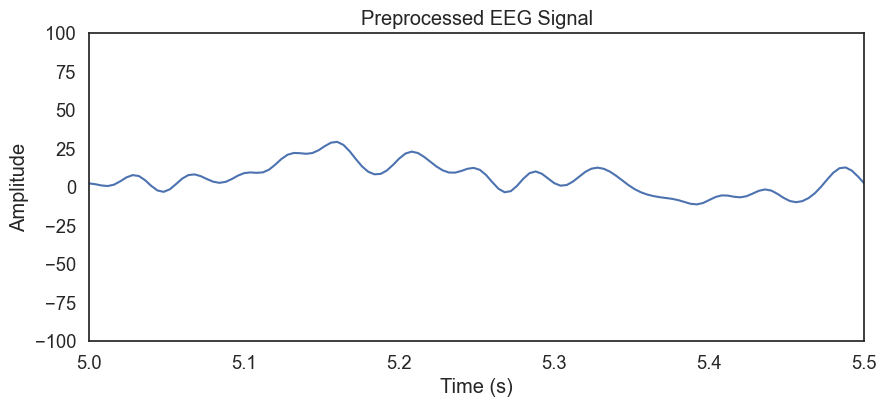

In [575]:
plot_signal(preprocessed_signal, "Preprocessed EEG Signal", (5, 5.5), (-100, 100))

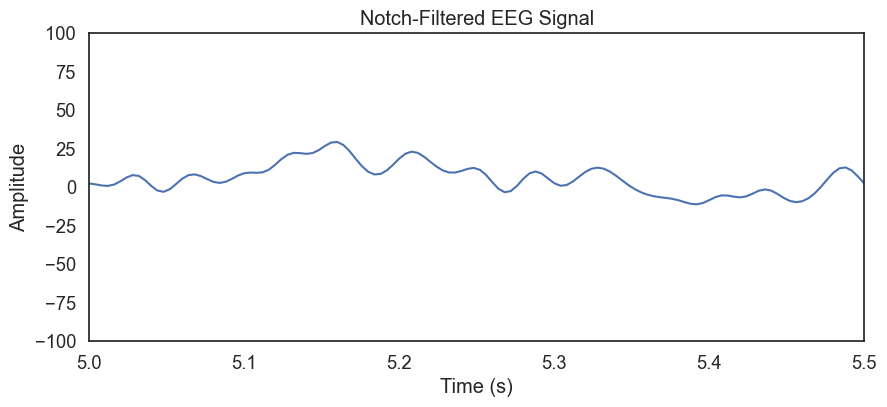

In [576]:
plot_signal(filtered_signal, "Notch-Filtered EEG Signal", (5, 5.5), (-100, 100))

# 4 EEG Band analysis using welch's method
**Input**: Run part 3 to get preprocessed eeg data for the selected participant.
**Output**: Images of band analysis

### 4.0 Explore the data using welch's method

Just exploratory, to check the spectrum distribution. Real calculation done in 3.5

In [577]:
win = 4 * fs # 4s window
freqs, psd = signal.welch(filtered_signal, fs, nperseg=win)

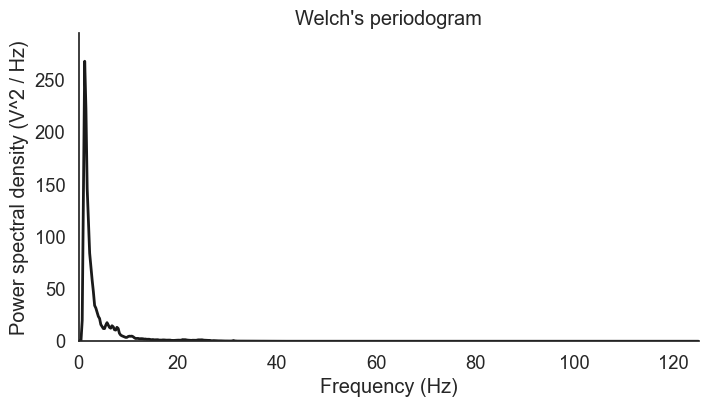

In [578]:
sns.set_theme(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
# plt.ylim([0, 10]) #
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
# plt.xlim([5, 30])
sns.despine()

### 4.1 Prepatory work

#### 4.1.1 Calculating function

Basic logic:
1. use welch's method to get the spectrum
2. use simpson's method to integrate the area of the band of interest.

In [579]:
def bandpower(data, band, window_sec=None, relative=False, fs=250):
    band = np.asarray(band)
    low, high = band

    if window_sec is not None:
        nperseg = window_sec * fs
    else:
        nperseg = (2 / low) * fs

    freqs, psd = welch(data, fs, nperseg=nperseg)
    freq_res = freqs[1] - freqs[0]
    idx_band = np.logical_and(freqs >= low, freqs <= high) # find closest indices of band
    bp = simpson(psd[idx_band], dx=freq_res) # integral approx. using Simpson's rule

    if relative:
        bp /= simpson(psd, dx=freq_res) # calculate the relative frequency
    return bp

#### 4.1.2 pick your chunk_size

In [580]:
chunk_size = 125 # 125 = 125 sampling points = 125/250 = 0.5 seconds

#### 4.1.3 pick your baseline window
Baseline window is a window where you go before the onset for a certain period, calculate the mean of that period, and divide the whole chunk's data by the mean during that period. It's like recalibrating for each chunk.

In [581]:
baseline_window_size = 25  # 25 Corresponds to -100ms (25ms/250Hz = 0.1s = 100ms)

#### 4.1.4 Some other stuff

In [582]:
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta": (13, 30),
    "Gamma": (30, 35)
}
band_values = {band: [] for band in bands}
time_stamps = []

window_sec = chunk_size/fs # how long is the chunk in terms of seconds (window in seconds)

time_idx_1 = int(27500/chunk_size) # this is for coloring the data, indicates onset of difficulty 2
time_idx_2 = int(55000/chunk_size) # for coloring the data, indicates onset of difficulty 3

### 4.2 Analysis

In [583]:
for start in range(0, dimension, chunk_size):
    end = start + chunk_size
    # get rid of the last part to avoid incomplete data
    # thats what I did in 1.4 where I make sure all data are at least 330 seconds long
    if end > dimension:
        break

    # baseline calculation
    if baseline_window_size != 0:
        if start-baseline_window_size >= 0:
            baseline_start = start - baseline_window_size
            baseline_end = start
        # if there are not enough data before the start to be used as baseline, use 0-25's data directly
        else:
            baseline_start = 0
            baseline_end = 25

        baseline_chunk = preprocessed_signal[baseline_start:baseline_end]
        baseline_mean = np.mean(baseline_chunk)
    else:
        baseline_mean = 0

    chunk = preprocessed_signal[start:end]
    normalized_chunk = chunk - baseline_mean

    for band in bands:
        band_value = bandpower(normalized_chunk, bands[band], window_sec=window_sec, relative=True)
        band_values[band].append(band_value)

    time_stamps.append(start / 250)

### 4.3 Postprocessing
1. remove outliers (>3SD) and interpolate them
2. Apply moving average for smoothing over window of 30s

#### 4.3.1 Before postprocessing

Maybe trim our data?

We pick only the presentation of question, skipping the result picking part

In [584]:
size_epoch = int(11/(chunk_size/fs)) # how many data for each trial
len_question = int(size_epoch*(5/11))
# len_question = 10
print(f"Now trimming data using {len_question} when each epoch is {size_epoch} ")
assert 660//size_epoch ==30  # should be 30, ensure this divides exactly

Now trimming data using 10 when each epoch is 22 


In [585]:
def select_question_only(data, size_epoch, len_question):
    picked_parts = []

    # iterate over each part
    for i in range(30):
        start_index = i * size_epoch
        picked_parts.extend(data[start_index:start_index + len_question])

    return picked_parts

def process_time_stamps(time_stamps, size_epoch, len_question):
    processed_times = []
    # find the new indices
    total_processed_length = 30 * len_question
    time_idx_1 = int(total_processed_length / 3)
    time_idx_2 = int(2 * total_processed_length / 3)

    # adjust indices to reflect the points selected from each segment
    for i in range(30):
        start_index = i * size_epoch
        processed_times.extend(time_stamps[start_index:start_index + len_question])

    return processed_times, time_idx_1, time_idx_2

In [586]:
new_band_values = {}
for band in band_values:
    new_band_values[band] = select_question_only(band_values[band], size_epoch, len_question)

new_time_stamps, time_idx_1, time_idx_2 = process_time_stamps(time_stamps, size_epoch, len_question)

print(len(new_band_values['Delta']))
print(f"{len(new_time_stamps)}, {time_idx_1}, {time_idx_2}")

300
300, 100, 200


In [587]:
band_values = new_band_values # do it if you ran the above code
time_stamps = new_time_stamps

#### 4.3.2 Now do the smoothing based on this data

In [588]:
# if the chunk_size is 250, it means 1s, we only need 30 chunks = 30 window size
# if the chunk_size is 125, then it means 0.5s, then we need 60 window size to have 30 seconds
window_size = int(30*250/chunk_size)
print(f"Currently a 30s window translates to {window_size} points.")
std_devs = 3

for band in band_values.keys():
    series = pd.Series(band_values[band])
    # remove outliers
    mean, std = series.mean(), series.std()
    without_outliers = series.where((series >= mean - std_devs * std) &
                                    (series <= mean + std_devs * std))

    # interpolation
    interpolated_series = without_outliers.interpolate()

    # apply moving average over the window size for smoothing
    smoothed_series = interpolated_series.rolling(window=window_size, center=True, min_periods=1).mean()
    band_values[band] = smoothed_series.tolist()

Currently a 30s window translates to 60 points.


### 4.4. Plotting

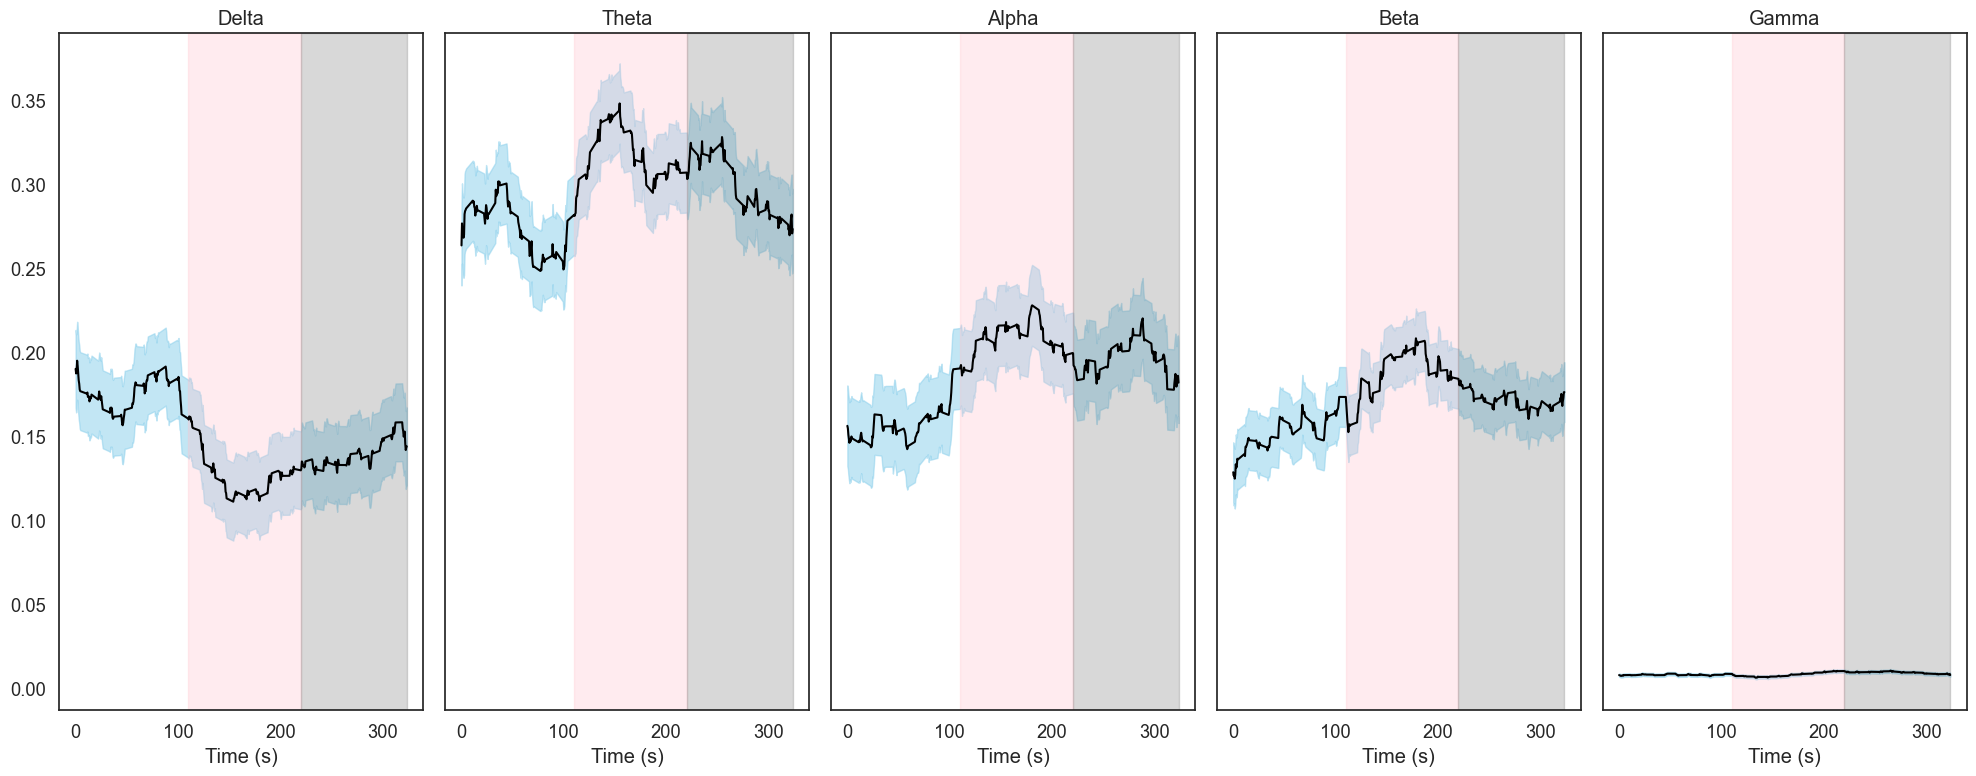

In [589]:
std_band_values = {band: np.std(band_values[band]) for band in bands}
fig, axs = plt.subplots(1, len(bands), figsize=(20, 8), sharey=True)

for i, band in enumerate(bands):
    # get the values/line to plot
    actual_values = band_values[band]
    # get the standard deviation for each band
    std_dev = std_band_values[band]
    # needed as background of the postprocessed values
    upper_bound = np.array(actual_values) + std_dev
    lower_bound = np.array(actual_values) - std_dev

    # plot values
    axs[i].plot(time_stamps, actual_values, label=f'{band} Actual', color='black')
    # plot the standard deviation as background
    axs[i].fill_between(time_stamps, lower_bound, upper_bound, color='skyblue', alpha=0.5, label=f'{band} Std Dev')
    # some parameters
    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Time (s)')
    # differentiate between three difficulties
    axs[i].axvspan(time_stamps[time_idx_1], time_stamps[time_idx_2], color='pink', alpha=0.3)
    axs[i].axvspan(time_stamps[time_idx_2], time_stamps[-1], color='grey', alpha=0.3)

plt.tight_layout()
plt.savefig(data_dir+participant+"Welch.png")
plt.show()

# 5 EEG Band analysis using STFT

### 5.1 STFT parameters

In [590]:
fs = 250  # sampling frequency
nperseg = 250  # window length for STFT
noverlap = nperseg // 2  # 50% overlap
stft_rel_power_band_values = {band: [] for band in bands}

### 5.2 We can do it on the whole data directly
No need to hand-batch

In [591]:
# compute the STFT, we can do it
freqs, times, Zxx = signal.stft(filtered_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
# calculate the total power at all points
total_power = np.abs(Zxx)**2

for band in bands:
    freq_range = bands[band]

    # extract the frequency range for the current band
    idx_band = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
    # find the current band's band power at that point
    band_power = np.abs(Zxx[idx_band, :])**2

    # find the total power at that time point
    total_power_at_each_time = np.sum(total_power, axis=0)  # Total power at each time point

    # divide band power by total power to get the relative power
    relative_band_power = np.sum(band_power, axis=0) / total_power_at_each_time
    stft_rel_power_band_values[band] = relative_band_power

### 5.3 Postprocessing
Same as above

In [592]:
window_size = int(30*250/chunk_size)
print(f"window size: {window_size}")
std_devs = 3

for band in stft_rel_power_band_values.keys():
    series = pd.Series(stft_rel_power_band_values[band])
    # remove outliers
    mean, std = series.mean(), series.std()
    without_outliers = series.where((series >= mean - std_devs * std) &
                                    (series <= mean + std_devs * std))

    # interpolation
    interpolated_series = without_outliers.interpolate()
    # apply moving average for smoothing
    smoothed_series = interpolated_series.rolling(window=window_size, center=True, min_periods=1).mean()
    stft_rel_power_band_values[band] = smoothed_series.tolist()

window size: 60


### 5.4 Plot the data

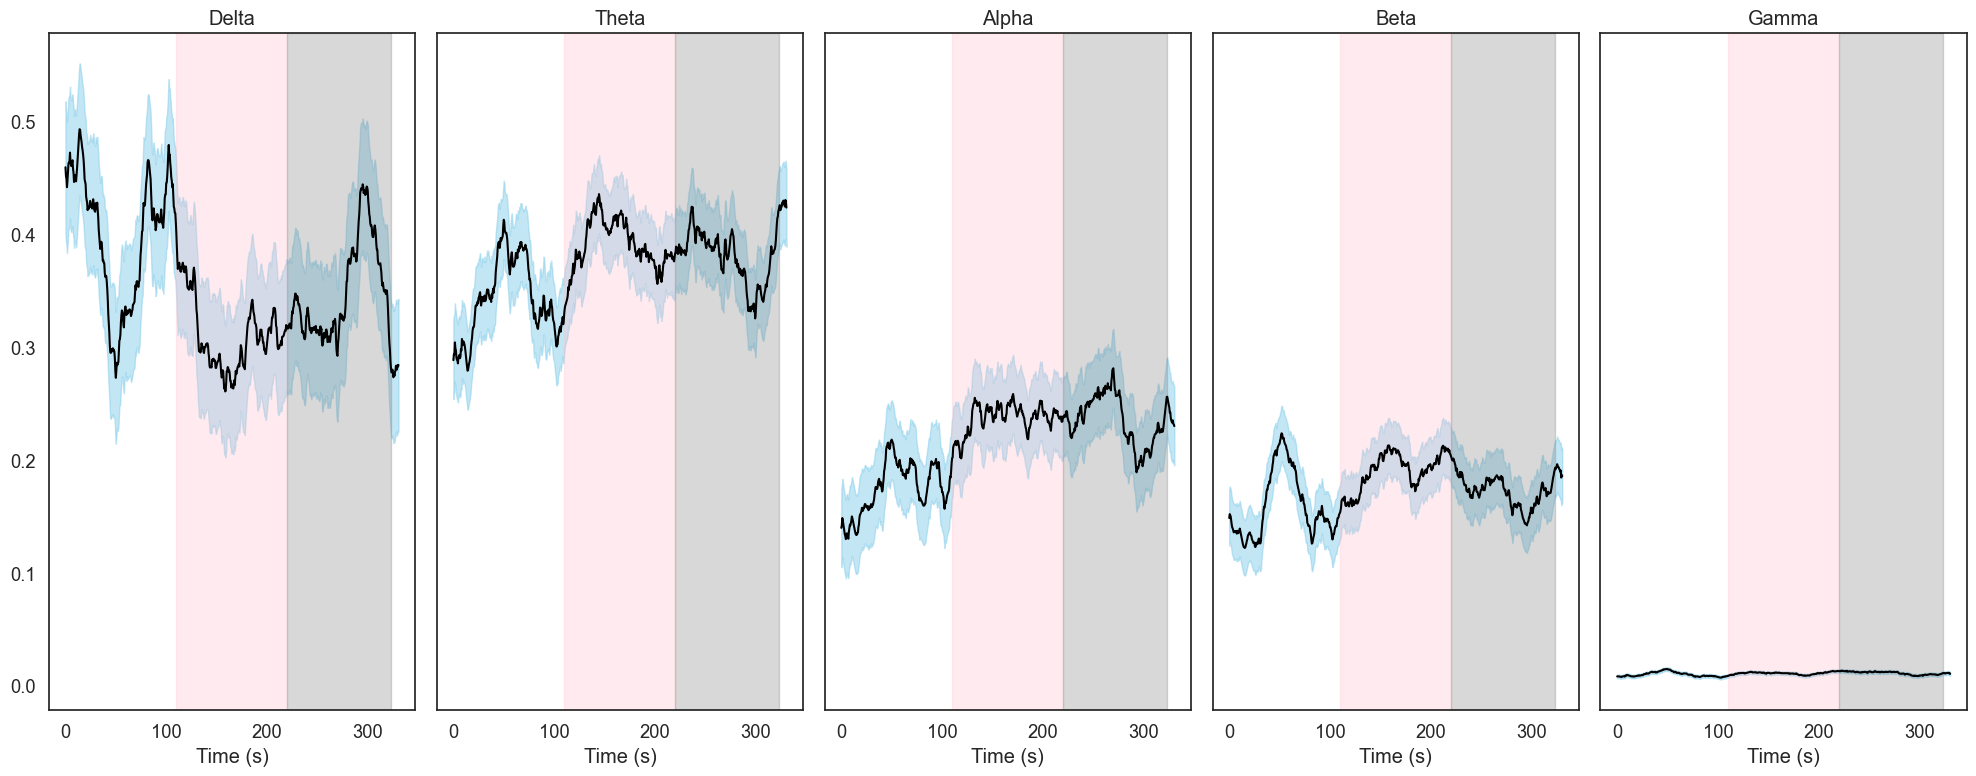

In [593]:
std_band_values = {band: np.std(stft_rel_power_band_values[band]) for band in bands}
fig, axs = plt.subplots(1, len(bands), figsize=(20, 8), sharey=True)

for i, band in enumerate(bands):
    actual_values = stft_rel_power_band_values[band]
    std_dev = std_band_values[band]
    upper_bound = np.array(actual_values) + std_dev
    lower_bound = np.array(actual_values) - std_dev

    axs[i].plot(times, actual_values, label=f'{band} Actual', color='black')
    axs[i].fill_between(times, lower_bound, upper_bound, color='skyblue', alpha=0.5, label=f'{band} Std Dev')

    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Time (s)')
    axs[i].axvspan(time_stamps[time_idx_1], time_stamps[time_idx_2], color='pink', alpha=0.3)
    axs[i].axvspan(time_stamps[time_idx_2], time_stamps[-1], color='grey', alpha=0.3)

plt.tight_layout()
plt.savefig(data_dir+participant+"STFT.png")
plt.show()

# 6 Importing it into MNE

In [400]:
import mne
from mne import Epochs, create_info
from mne.baseline import rescale
from mne.io import RawArray
from mne.time_frequency import (
    AverageTFR,
    tfr_array_morlet,
    tfr_morlet,
    tfr_multitaper,
    tfr_stockwell,
)
from mne.viz import centers_to_edges

# %matplotlib qt

In [594]:
n_channels = 1
sampling_freq = 250  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
ch_names = [f"IDUN"]
ch_types = ["eeg"]
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)

### 6.1 Epoched Version (not used for now)

https://mne.tools/dev/auto_tutorials/simulation/10_array_objs.html

In [595]:
eeg_array = filtered_signal
epoch_size = len(eeg_array) //30
assert epoch_size == 2750
eeg_array_resized = eeg_array[:30 * epoch_size]
eeg_epochs = eeg_array_resized.reshape(30, epoch_size)
print(len(eeg_epochs), len(eeg_epochs[0]))
eeg_epochs = eeg_epochs[:, np.newaxis, :]  # this changes the shape from (30, 2750) to (30, 1, 2750)
epochs = mne.EpochsArray(eeg_epochs, info)
epochs.plot(picks="eeg", n_channels=1, show_scrollbars=True, events=True)

30 2750
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Using pyopengl with version 3.1.6


We need one more dimension n_channels to pass this data in to MNE

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...
Need more than one channel to make topography for eeg. Disabling interactivity.


/var/folders/sn/899h__m10ts8yb683c1ymjlr0000gn/T/ipykernel_5124/1679122028.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs.compute_psd().plot(picks="eeg")
/Users/askr/miniforge3/envs/mne_env/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


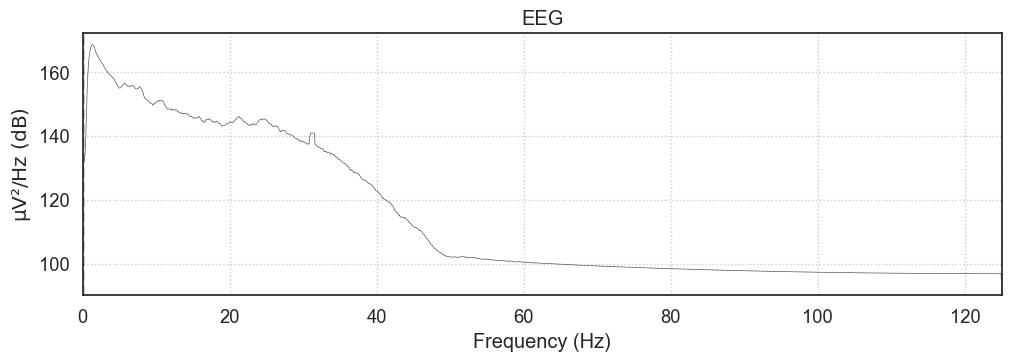

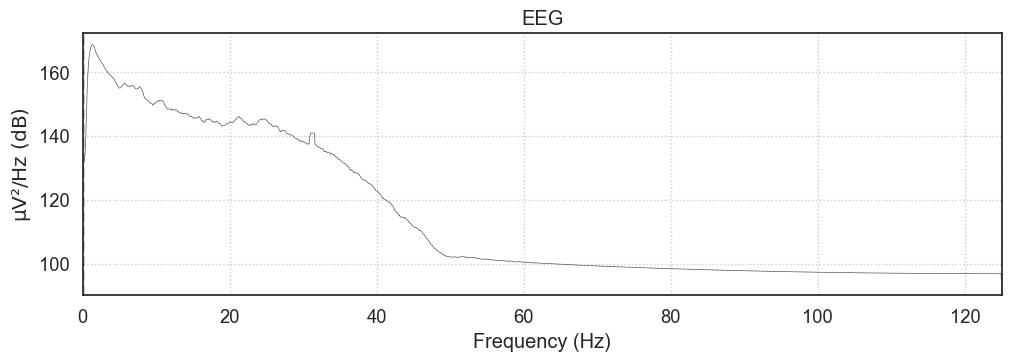

Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [596]:
epochs.compute_psd().plot(picks="eeg")

### 6.2 Continuous version (used for now)

#### 6.2.1 Loading data

In [597]:
n_samples = len(eeg_array)
data = eeg_array[np.newaxis, :]  # Add an extra dimension for the channel
continuous_data = mne.io.RawArray(data, info)
raw = mne.io.RawArray(data, info)
# raw.plot(show_scrollbars=False, show_scalebars=False)

Creating RawArray with float64 data, n_channels=1, n_times=82504
    Range : 0 ... 82503 =      0.000 ...   330.012 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=82504
    Range : 0 ... 82503 =      0.000 ...   330.012 secs
Ready.


Effective window size : 8.192 (s)


/Users/askr/miniforge3/envs/mne_env/lib/python3.12/site-packages/mne/viz/utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


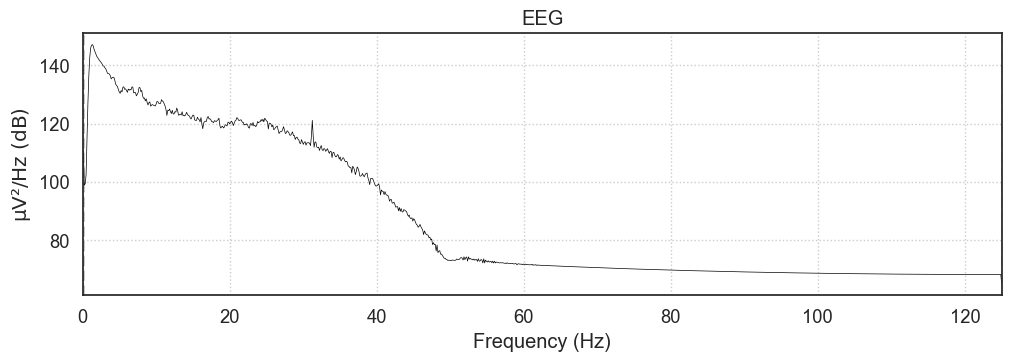

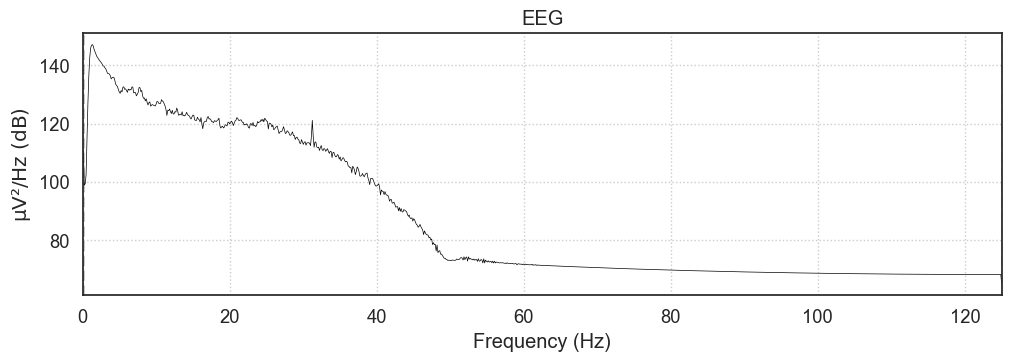

In [598]:
# check spectrum
spectrum = raw.compute_psd()
spectrum.plot(average=True, picks="eeg", exclude="bads")

In [599]:
# use one single epoch for whole data
epochs_single = mne.make_fixed_length_epochs(raw, duration=330, preload=False)

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


#### 6.2.2 Signal processing

In [600]:
# do wavelet transform
freqs = np.arange(0.5, 35.1, 0.1)
n_cycles = freqs / 2.0
decim = 5
power, itc = tfr_morlet(
    epochs_single[0],
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=decim,
    n_jobs=None,
)

Using data from preloaded Raw for 1 events and 82500 original time points ...
0 bad epochs dropped


In [601]:
# calculate relative band power
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 35)
}

total_power = np.sum(power.data, axis=1, keepdims=True)  # shape: (n_channels, 1, n_times)
relative_band_power = {}

for band, (low_freq, high_freq) in bands.items():
    idx = np.where((freqs >= low_freq) & (freqs <= high_freq))[0]
    band_power = np.sum(power.data[:, idx, :], axis=1)
    relative_band_power[band] = (band_power / total_power).squeeze()

relative_band_power

{'Delta': array([0.20311411, 0.11908378, 0.06031401, ..., 0.11277282, 0.08779133,
        0.08043646]),
 'Theta': array([0.32323115, 0.34060144, 0.35488543, ..., 0.50182754, 0.47997728,
        0.44517259]),
 'Alpha': array([0.2462139 , 0.27198232, 0.28400353, ..., 0.21899038, 0.2547083 ,
        0.28221948]),
 'Beta': array([0.20313744, 0.24688149, 0.28391709, ..., 0.16484321, 0.1763794 ,
        0.19117235]),
 'Gamma': array([0.02430341, 0.02145097, 0.01687994, ..., 0.00156604, 0.00114369,
        0.00099912])}

In [602]:
# smoothing
std_devs = 4  # Number of standard deviations to consider for outlier removal
window_size = 2000 # ((82500/5(decim))/330) = 50 sampling points per second, 1500 is 30s (same as whitepaper)
smoothed_rel_band_power = {}

for band in relative_band_power.keys():
    series = pd.Series(relative_band_power[band])
    mean = series.mean()
    std = series.std()
    # Remove outliers
    without_outliers = series.where((series >= mean - std_devs * std) &
                                    (series <= mean + std_devs * std))
    interpolated_series = without_outliers.interpolate()
    smoothed_series = interpolated_series.rolling(window=window_size, center=True, min_periods=1).mean()
    smoothed_rel_band_power[band] = smoothed_series.tolist()

In [603]:
# set the timestamps for plotting
time_stamps = (power.times)  # Directly use the times provided by the TFR computation
time_idx_1 = len(time_stamps) // 3
time_idx_2 = 2 * len(time_stamps) // 3
print(len(time_stamps), time_idx_1, time_idx_2)

# calculate the std for plotting the blue background
std_band_values = {band: np.std(values, axis=0) for band, values in smoothed_rel_band_power.items()}

16500 5500 11000


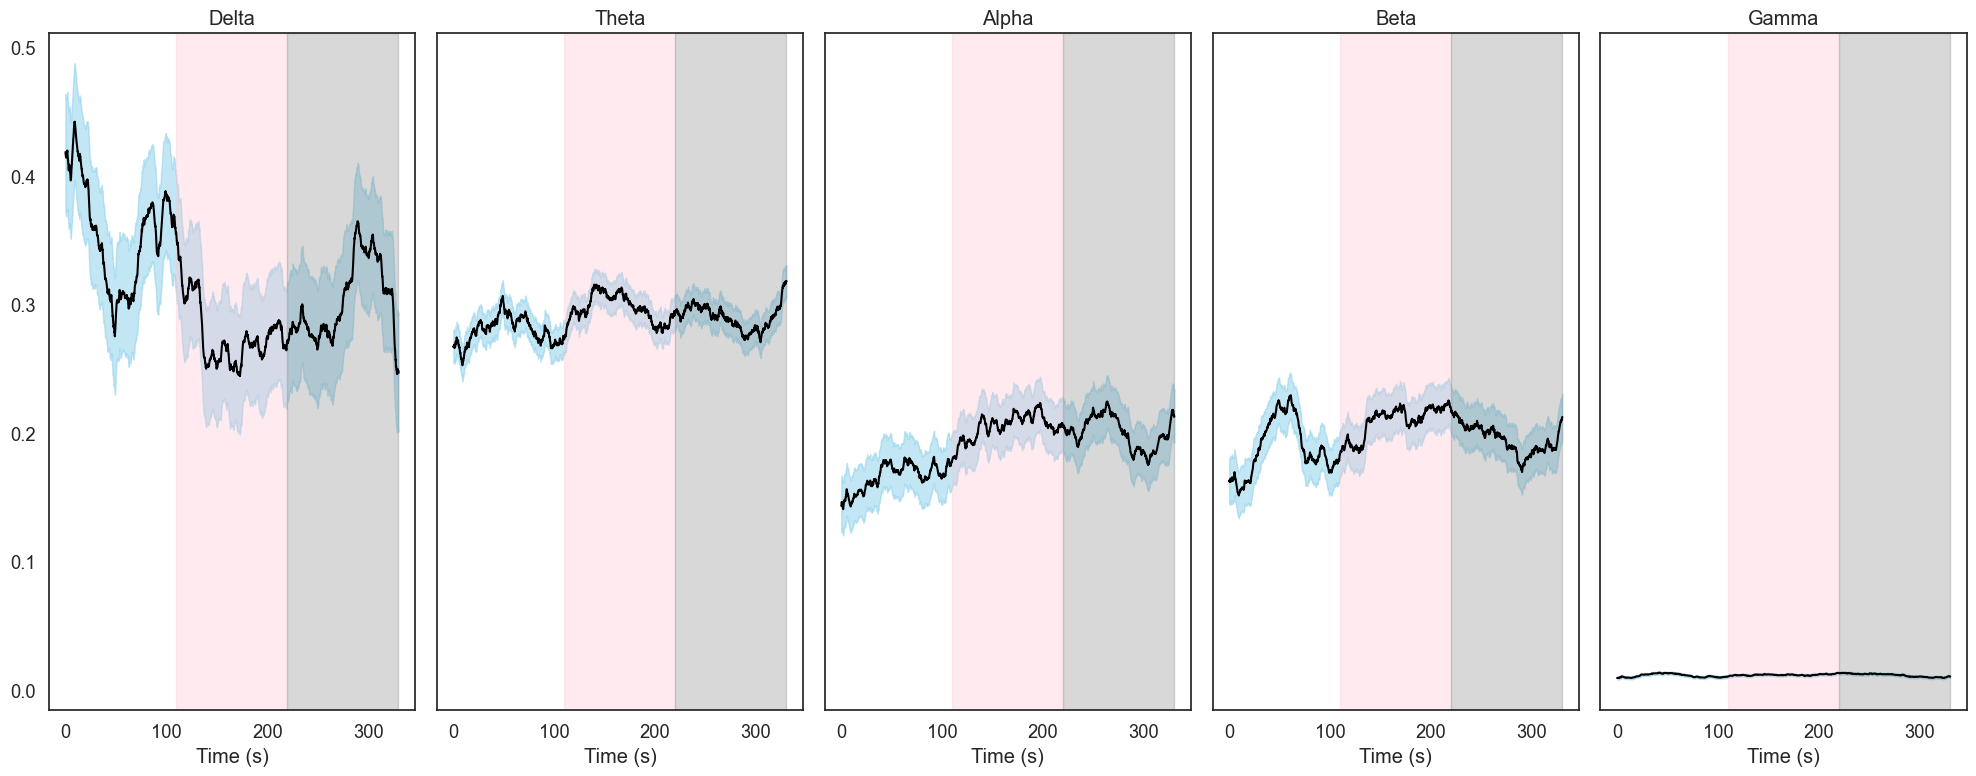

In [604]:
# plot!

fig, axs = plt.subplots(1, len(bands), figsize=(20, 8), sharey=True)

for i, (band, values) in enumerate(smoothed_rel_band_power.items()):
    actual_values = values  # ensure 1d
    std_dev = std_band_values[band].squeeze()  # ensure 1d
    upper_bound = actual_values + std_dev
    lower_bound = actual_values - std_dev

    axs[i].plot(time_stamps, actual_values, label=f'{band} Actual', color='black')
    axs[i].fill_between(time_stamps, lower_bound, upper_bound, color='skyblue', alpha=0.5, label=f'{band} Std Dev')
    
    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Time (s)')
    
    axs[i].axvspan(time_stamps[time_idx_1], time_stamps[time_idx_2], color='pink', alpha=0.3)
    axs[i].axvspan(time_stamps[time_idx_2], time_stamps[-1], color='grey', alpha=0.3)

plt.tight_layout()
plt.show()

# 7 Group Analysis using STFT

### 7.1 Similar to part 3, read in all the data

In [435]:
num_participants = 5

In [436]:
eeg_data_dict = {}

for i in range(1, num_participants+1):
    participant = f"{i:02}"
    eeg_name = participant + "_paired.csv"
    eeg_data_df = pd.read_csv(data_dir + eeg_name)
    eeg_data = eeg_data_df['ch1']
    preprocessed_signal = preprocess_eeg(eeg_data, fs)
    filtered_signal = apply_notch_filter(preprocessed_signal)
    dimension = len(eeg_data_df)
    eeg_data_dict[participant] = {
        'filtered_eeg': filtered_signal,
        'dimension': dimension
    }

### 7.2 Use STFT to do time frequency analysis

In [437]:
fs = 250
nperseg = 125
noverlap = nperseg // 2
bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 35)
}

participants_stft = {}

for i in range(1, num_participants+1):
    participant = f"{i:02}"
    filtered_signal = eeg_data_dict[participant]['filtered_eeg']

    # calculate frequency 
    freqs, times, Zxx = signal.stft(filtered_signal, fs=fs, nperseg=nperseg, noverlap=noverlap)
    total_power = np.abs(Zxx)**2

    # storage
    stft_rel_power_band_values = {band: [] for band in bands}

    # for each band
    for band in bands:
        # get the freq range, use this to concatenate band power
        freq_range = bands[band]
        idx_band = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
        band_power = np.abs(Zxx[idx_band, :])**2
        # get total power at each time
        total_power_at_each_time = np.sum(total_power, axis=0)  # Total power at each time point
        # get relative power at each time
        relative_band_power = np.sum(band_power, axis=0) / total_power_at_each_time
        stft_rel_power_band_values[band] = relative_band_power

    # for each participant, store the data
    participants_stft[participant] = stft_rel_power_band_values

In [438]:
times[874]

220.248

### 7.3 Smoothign

In [439]:
fs = 250 
std_devs = 3
dt = times[-1] / (len(times) - 1) # interval - assume evenly spaced
window_size = int(30 / dt)
all_smoothed = {}
for i in range(1, num_participants+1):
    participant = f"{i:02}"
    data = participants_stft[participant]
    current_smoothed = {}

    for band in data.keys():
        series = pd.Series(data[band])
        
        # Remove outliers
        mean = series.mean()
        std = series.std()
        without_outliers = series.where((series >= mean - std_devs * std) &
                                        (series <= mean + std_devs * std))
        # Interpolation
        interpolated_series = without_outliers.interpolate()

        # Apply moving average for smoothing
        smoothed_series = interpolated_series.rolling(window=window_size, center=True, min_periods=1).mean()

        # Replace the original data with the smoothed data
        current_smoothed[band] = smoothed_series.tolist()

    all_smoothed[participant] = current_smoothed

### 7.4 Plot

In [440]:
all_bands_data = {band: [] for band in bands}

for participant in all_smoothed:
    for band in bands:
        all_bands_data[band].append(all_smoothed[participant][band])

mean_band_values = {band: np.mean(all_bands_data[band], axis=0) for band in bands}
std_band_values = {band: np.std(all_bands_data[band], axis=0) for band in bands}

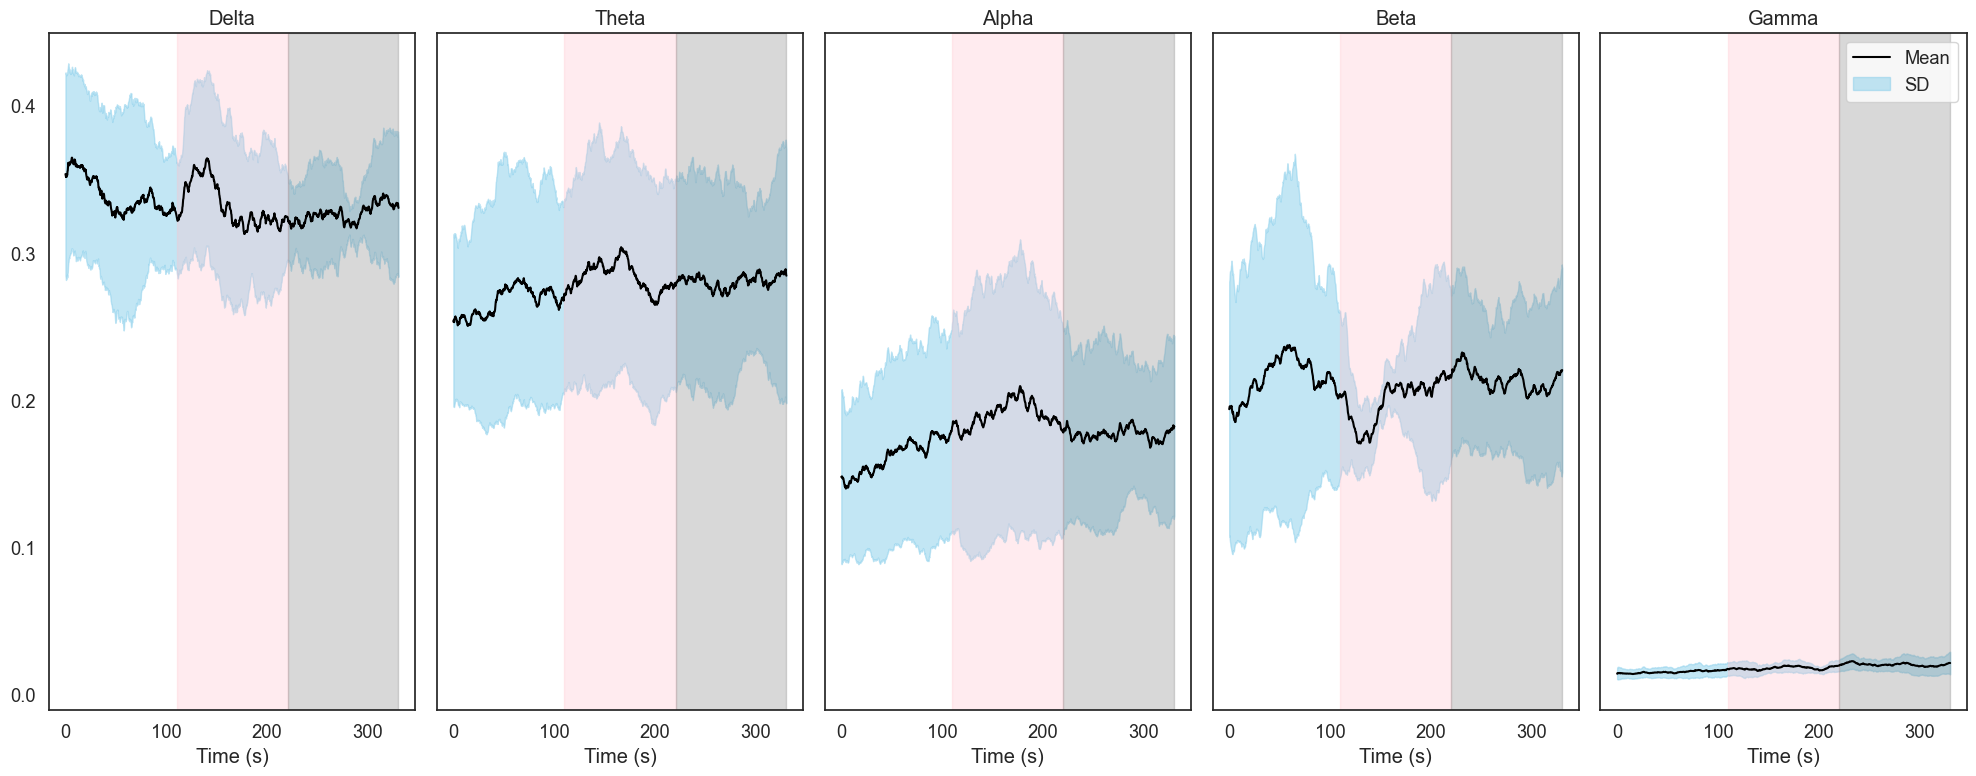

In [441]:
fig, axs = plt.subplots(1, len(bands), figsize=(20, 8), sharey=True)

for i, band in enumerate(bands):
    actual_values = mean_band_values[band]
    std_dev = std_band_values[band]
    upper_bound = np.array(actual_values) + std_dev
    lower_bound = np.array(actual_values) - std_dev

    time_idx_1 = len(times)//3
    time_idx_2 = 2*len(times)//3

    axs[i].plot(times, actual_values, label=f'Mean', color='black')
    axs[i].fill_between(times, lower_bound, upper_bound, color='skyblue', alpha=0.5, label=f'SD')
    
    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Time (s)')

    axs[i].axvspan(times[time_idx_1], times[time_idx_2], color='pink', alpha=0.3)
    axs[i].axvspan(times[time_idx_2], times[-1], color='grey', alpha=0.3)

plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig(data_dir + "Aggregate_STFT.png")
plt.show()


# 8 Group Analysis using welch's method

### 8.1 Read in all data

In [442]:
num_participants = 5

In [443]:
eeg_data_dict = {}

for i in range(1, num_participants+1):
    participant = f"{i:02}"
    eeg_name = participant + "_paired.csv"
    eeg_data_df = pd.read_csv(data_dir + eeg_name)
    eeg_data = eeg_data_df['ch1']
    preprocessed_signal = preprocess_eeg(eeg_data, fs)
    filtered_signal = apply_notch_filter(preprocessed_signal)
    dimension = len(eeg_data_df)
    eeg_data_dict[participant] = {
        'filtered_eeg': filtered_signal,
        'dimension': dimension
    }

### 8.2 Do welch's analysis
Before running, make sure you already run 4.2 to initialize parameters

In [444]:
print("Currently processing: ")
print(f"Chunk size: {1000*chunk_size/250} ms")
print(f"Baseline: {1000*baseline_window_size/250} ms")

Currently processing: 
Chunk size: 500.0 ms
Baseline: 100.0 ms


In [445]:
participants_welch = {}

for i in range(1, num_participants+1):
    participant = f"{i:02}"
    filtered_signal = eeg_data_dict[participant]['filtered_eeg']
    dimension = eeg_data_dict[participant]['dimension']
 
    current_participant = {band: [] for band in bands}

    for start in range(0, dimension, chunk_size):
        end = start + chunk_size
        if end > dimension:
            break

        # baseline calculation
        if baseline_window_size != 0:
            if start-baseline_window_size >= 0:
                baseline_start = start - baseline_window_size
                baseline_end = start
            # if there are not enough data before the start to be used as baseline, use 0-25's data directly
            else:
                baseline_start = 0
                baseline_end = 25

            baseline_chunk = filtered_signal[baseline_start:baseline_end]
            baseline_mean = np.mean(baseline_chunk)
        else:
            baseline_mean = 0

        chunk = filtered_signal[start:end]
        normalized_chunk = chunk - baseline_mean

        for band in bands:
            current_band_value = bandpower(normalized_chunk, bands[band], window_sec=window_sec, relative=True)
            current_participant[band].append(current_band_value)

    participants_welch[participant] = current_participant

times = np.arange(0, 330, 0.5)

### 8.3 Smoothing

In [446]:
fs = 250 
std_devs = 3
window_size = int(30*250/chunk_size) # 30s
print(f"Current window size: {window_size}")
all_smoothed_welch = {}

for i in range(1, num_participants+1):
    participant = f"{i:02}"
    data = participants_welch[participant]
    current_smoothed = {}

    for band in data.keys():
        series = pd.Series(data[band])
        
        # Remove outliers
        mean = series.mean()
        std = series.std()
        without_outliers = series.where((series >= mean - std_devs * std) &
                                        (series <= mean + std_devs * std))
        # Interpolation
        interpolated_series = without_outliers.interpolate()

        # Apply moving average for smoothing
        smoothed_series = interpolated_series.rolling(window=window_size, center=True, min_periods=1).mean()
        current_smoothed[band] = smoothed_series.tolist()

    all_smoothed_welch[participant] = current_smoothed

Current window size: 60


In [447]:
len(all_smoothed_welch['02']['Delta'])

660

### 8.4 Plot

In [448]:
all_bands_data_welch = {band: [] for band in bands}

for participant in all_smoothed_welch:
    for band in bands:
        all_bands_data_welch[band].append(all_smoothed_welch[participant][band])

mean_band_values_welch = {band: np.mean(all_bands_data_welch[band], axis=0) for band in bands}
std_band_values_welch = {band: np.std(all_bands_data_welch[band], axis=0) for band in bands}

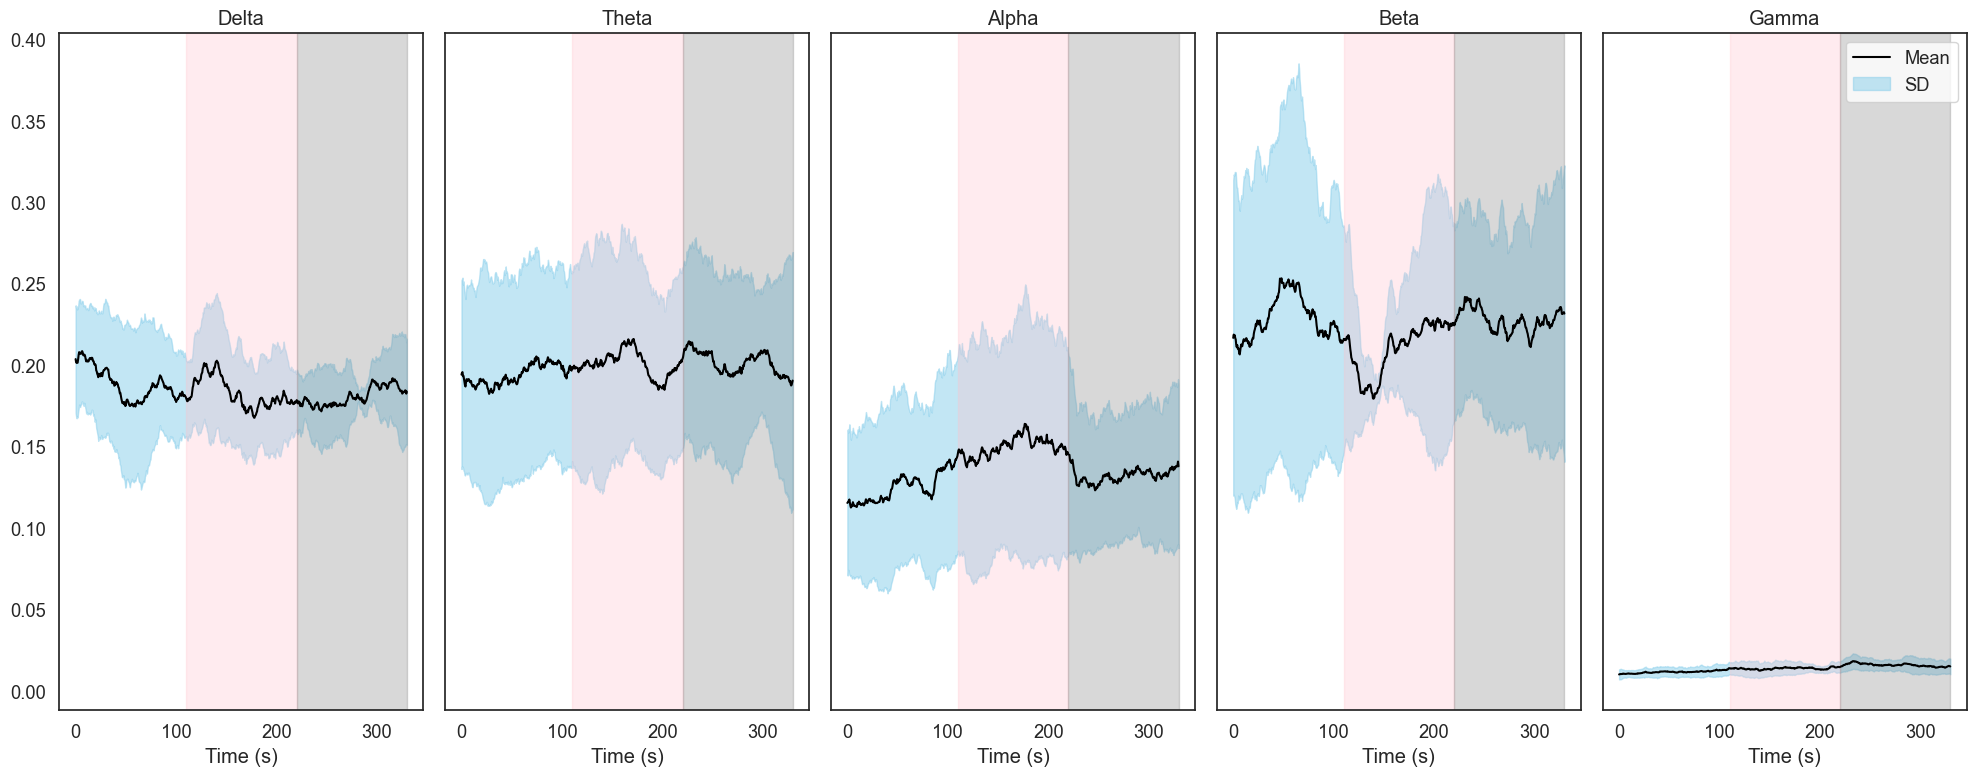

In [449]:
fig, axs = plt.subplots(1, len(bands), figsize=(20, 8), sharey=True)

for i, band in enumerate(bands.keys()):
    actual_values = mean_band_values_welch[band]
    std_dev = std_band_values_welch[band]
    upper_bound = np.array(actual_values) + std_dev
    lower_bound = np.array(actual_values) - std_dev

    time_idx_1 = len(times)//3
    time_idx_2 = 2*len(times)//3

    axs[i].plot(times, actual_values, label=f'Mean', color='black')
    axs[i].fill_between(times, lower_bound, upper_bound, color='skyblue', alpha=0.5, label=f'SD')
    
    axs[i].set_title(f'{band}')
    axs[i].set_xlabel('Time (s)')

    axs[i].axvspan(times[time_idx_1], times[time_idx_2], color='pink', alpha=0.3)
    axs[i].axvspan(times[time_idx_2], times[-1], color='grey', alpha=0.3)

plt.tight_layout()
plt.legend(loc='upper right')
plt.savefig(data_dir + "Aggregate_Welch.png")
plt.show()


In [287]:
len(time_stamps)

3300

# 9 Archived codes

In [ ]:
def find_cls(eeg_data, window_sec=1, fs=250):
    """
    Calculate the Cognitive Load Score (CLS) based on band powers.
    :param eeg_data: input array of eeg_dasta
    :return: CLS score.
    """
    # relative is false because if set to true it calculates from all
    delta = bandpower(eeg_data, fs, [0.5,4], window_sec=window_sec, relative=False)
    # print("deta", delta)
    alpha = bandpower(eeg_data, fs, [4,8], window_sec=window_sec, relative=False)
    # print("alpha", alpha)
    beta = bandpower(eeg_data, fs, [13,30], window_sec=window_sec, relative=False)
    # print("beta", beta)
    sigma = bandpower(eeg_data, fs, [11,16], window_sec=window_sec, relative=False)
    if sigma == 0:
        print("Sigma not found")
    cls = delta / (alpha+beta+sigma)
    return cls

In [ ]:
all_band_powers = {band: [] for band in bands}

# concatenate all participants
for participant in all_band_values:
    for band in bands:
        all_band_powers[band].extend(participant[band])

# Z-score normalization
z_norm_band_values = []
for participant in all_band_values:
    participant_norm_band_values = {}
    for band in bands:
        mean_band_power = np.mean(all_band_powers[band])
        std_band_power = np.std(all_band_powers[band])

        if std_band_power != 0:
            participant_norm_band_values[band] = [(x - mean_band_power) / std_band_power for x in participant[band]]
        else:
            participant_norm_band_values[band] = [0 for _ in participant[band]] # all zero values...?

    z_norm_band_values.append(participant_norm_band_values)

# global min max normalization
global_min = min(min(min(values) for values in participant.values()) for participant in all_band_values)
global_max = max(max(max(values) for values in participant.values()) for participant in all_band_values)
min_max_normalized_band_values = []
for participant in all_band_values:
    participant_norm_band_values = {}
    for band in bands:
        participant_norm_band_values[band] = [(x - global_min) / (global_max - global_min) for x in participant[band]]
    min_max_normalized_band_values.append(participant_norm_band_values)

In [ ]:
type(participant_norm_band_values)

dict

In [ ]:
from scipy.signal import welch, detrend, butter, filtfilt

def calculate_band_power(eeg_data, fs):
    """
    Calculate band power for different EEG bands.
    :param eeg_data: The preprocessed EEG data.
    :param fs: Sampling frequency.
    :return: Dictionary with band powers.
    """
    # Define the EEG bands
    eeg_bands = {'Delta': (0.5, 4), 'Theta': (4, 8), 'Alpha': (8, 13),
                 'Beta': (13, 30), 'Gamma': (30, 100), 'Sigma': (11, 16)}

    band_power = {}
    freqs, psd = welch(eeg_data, fs, nperseg=4*fs, scaling='spectrum')

    for band in eeg_bands:
        freq_range = eeg_bands[band]
        idx_band = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
        band_power[band] = np.sum(psd[idx_band])

    return band_power

def calculate_cls(band_power):
    """
    Calculate the Cognitive Load Score (CLS) based on band powers.
    :param band_power: Dictionary with band powers.
    :return: CLS score.
    """
    cls = band_power['Delta'] / (band_power['Alpha'] + band_power['Beta'] + band_power['Sigma'])
    return cls

# Convert the Pandas Series to a NumPy array
# eeg_signal = volmy_dattage.values
eeg_signal = my_data

# Real-time processing loop, adapted for Pandas Series
fs = 250  # Sampling frequency of the EEG device

# Process in chunks (e.g., 1 second of data each time)
chunk_size = fs  # Process 1 second of data at a time
for start in range(0, len(eeg_signal), chunk_size):
    chunk = eeg_signal[start:start + chunk_size]
    preprocessed_chunk = preprocess_eeg(chunk, fs)
    band_power = calculate_band_power(preprocessed_chunk, fs)
    cls = calculate_cls(band_power)
    print(f"Cognitive Load Score at {start/fs} seconds: {cls}")

Cognitive Load Score at 0.0 seconds: 20.39099317636498
Cognitive Load Score at 1.0 seconds: 12.149531420396753
Cognitive Load Score at 2.0 seconds: 19.47149780885163
Cognitive Load Score at 3.0 seconds: 55.50421500241273
Cognitive Load Score at 4.0 seconds: 31.078454535039903
Cognitive Load Score at 5.0 seconds: 24.920831256653933
Cognitive Load Score at 6.0 seconds: 13.7419724676117
Cognitive Load Score at 7.0 seconds: 80.60620458600424
Cognitive Load Score at 8.0 seconds: 72.95666383107155
Cognitive Load Score at 9.0 seconds: 9.425999735932976
Cognitive Load Score at 10.0 seconds: 21.47983583369813
Cognitive Load Score at 11.0 seconds: 23.312158138887717
Cognitive Load Score at 12.0 seconds: 3.5858230881770345
Cognitive Load Score at 13.0 seconds: 5.675192835731203
Cognitive Load Score at 14.0 seconds: 5.590748753349242
Cognitive Load Score at 15.0 seconds: 9.03562247767104
Cognitive Load Score at 16.0 seconds: 15.894111178171944
Cognitive Load Score at 17.0 seconds: 27.2305444899611

/usr/local/lib/python3.10/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 1000 is greater than input length  = 249, using nperseg = 249
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [ ]:
# assigning the channel type when initializing the info object
# ch_names = ['TimeSecs misc', 'EEG_ch1 eeg']
# ch_types = ['misc', 'eeg']

# if you want the event marker:
# ch_names = ['TimeSecs misc', 'EEG_ch1 eeg', 'Event misc']
# ch_types = ['misc', 'eeg', 'misc']

# since we only take the values column, we do below:
ch_names = ['EEG_ch1']
ch_types = ['eeg']

fs = 250  # in Hertz
info = mne.create_info(ch_names= ch_names, ch_types= ch_types, sfreq= fs)
raw = mne.io.RawArray(preprocessed_data, info)

Creating RawArray with float64 data, n_channels=1, n_times=82496
    Range : 0 ... 82495 =      0.000 ...   329.980 secs
Ready.


In [ ]:
raw

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,1 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [ ]:
%matplotlib inline
raw.plot(scalings="auto")

ImportError: Failed to import any of the following Qt binding modules: PyQt6, PySide6, PyQt5, PySide2

In [ ]:
!pip install PySide6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.8/511.8 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.2/171.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 MB 3.9 MB/s eta 0:00:00


Effective window size : 8.192 (s)


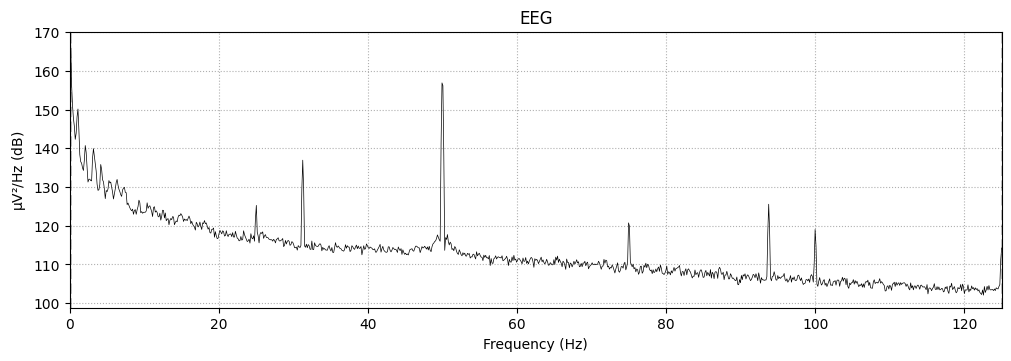

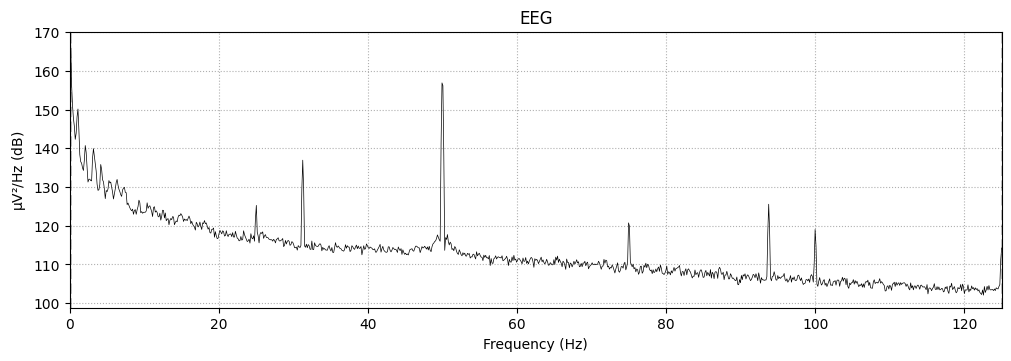

In [ ]:
spectrum = raw.compute_psd()
spectrum.plot(average=True, picks="data", exclude="bads", amplitude=False)

In [ ]:
epochs = mne.make_fixed_length_epochs(raw, duration=30, preload=False)

Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated


In [ ]:
epochs

Number of events,10
Events,1: 10
Time range,0.000 – 29.996 s
Baseline,off


In [ ]:
# event_related_plot = epochs.plot_image(picks=["MEG 1142"])

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0
power, itc = tfr_morlet(
    epochs[0],
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


Using data from preloaded Raw for 1 events and 7500 original time points ...
0 bad epochs dropped


Applying baseline correction (mode: logratio)


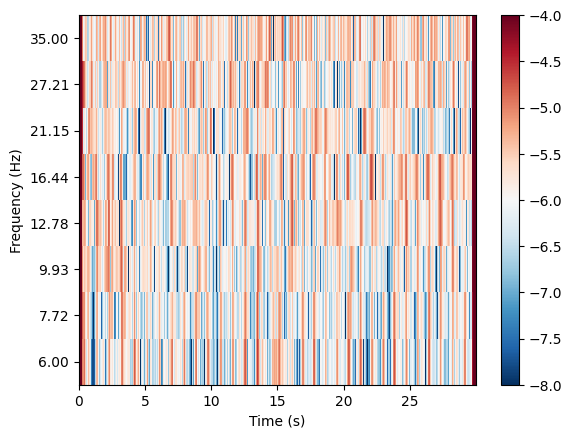

Text(0.5, 1.0, 'Time-Frequency Representation of EEG_ch1')

In [ ]:
fig, ax = plt.subplots()
power.plot(
    [0],
    axes=ax,
    baseline=(0.0, 0.1),
    mode='logratio',
    vmin = -8,
    vmax = -4,
    show=True,
    colorbar = True)
ax.set_title(f'Time-Frequency Representation of {power.ch_names[0]}')

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0
power, itc = tfr_morlet(
    epochs[9],
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


Using data from preloaded Raw for 1 events and 7500 original time points ...
0 bad epochs dropped


Applying baseline correction (mode: logratio)


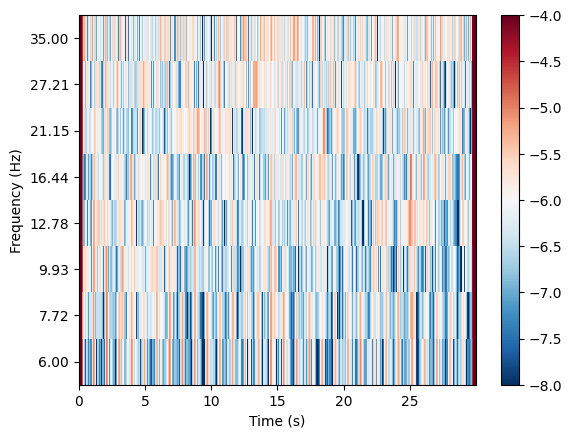

Text(0.5, 1.0, 'Time-Frequency Representation of EEG_ch1')

In [ ]:
fig, ax = plt.subplots()
power.plot(
    [0],
    axes=ax,
    baseline=(0.0, 0.1),
    mode='logratio',
    vmin = -8,
    vmax = -4,
    show=True,
    colorbar = True)
ax.set_title(f'Time-Frequency Representation of {power.ch_names[0]}')

In [ ]:
print("Number of epochs:", len(epochs))
print("Epochs info:", epochs.info)

Number of epochs: 10
Epochs info: <Info | 7 non-empty values
 bads: []
 ch_names: EEG_ch1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>


In [ ]:
# crop and resample just to reduce computation time
raw.crop(120, 360).load_data().resample(200)
events = mne.find_events(raw, stim_channel="STI 014")

# picks MEG gradiometers
picks = mne.pick_types(raw.info, meg="grad", eeg=False, eog=True, stim=False)

# construct epochs
event_id, tmin, tmax = 1, -1.0, 3.0
baseline = (None, 0)
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=baseline,
    reject=dict(grad=4000e-13, eog=350e-6),
    preload=True,
)

Using default location ~/mne_data for somato...
Creating ~/mne_data


 99%|██████████████████████████████████████▋| 605M/611M [00:25<00:00, 21.8MB/s]

KeyboardInterrupt: 

In [ ]:
freqs = np.arange(5.0, 100.0, 3.0)
vmin, vmax = -3.0, 3.0  # Define our color limits.

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, layout="constrained")
for n_cycles, time_bandwidth, ax, title in zip(
    [freqs / 2, freqs, freqs / 2],  # number of cycles
    [2.0, 4.0, 8.0],  # time bandwidth
    axs,
    [
        "Sim: Least smoothing, most variance",
        "Sim: Less frequency smoothing,\nmore time smoothing",
        "Sim: Less time smoothing,\nmore frequency smoothing",
    ],
):
    power = tfr_multitaper(
        epochs,
        freqs=freqs,
        n_cycles=n_cycles,
        time_bandwidth=time_bandwidth,
        return_itc=False,
    )
    ax.set_title(title)
    # Plot results. Baseline correct based on first 100 ms.
    power.plot(
        [0],
        baseline=(0.0, 0.1),
        mode="mean",
        vmin=vmin,
        vmax=vmax,
        axes=ax,
        show=False,
        colorbar=False,
    )